In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.output_stderr').hide();
 } else {
 $('div.input').show();
 $('div.output_stderr').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action='javascript:code_toggle()'><input STYLE='color: #4286f4' 
type='submit' value='Click here to toggle on/off the raw code.'></form>''')

# <center> Small World Phenomenon on Twitter Data   </center>

## <center> $\textit{Second Short Report} $ </center>

### <center> Data Science Laboratory </center>

<center> <img src="elte_cimer_szines.jpg" alt="elte_cimer" width="260"/> </center>

_Disclaimer: if you do not see the raw code, consider toggling them at the top of the page_

### Introduction 

The purpose of this report is to have a brief summary about my work since last week. Before last week's lesson I was able to gather tweets based on their locations and to tokenize thw words.

### About last week

My progress so far:

- Stream tweets via the $\texttt{tweepy}$ package
- Choose them by locations
- Prepare the data from .json format
- Tokenize the words in the tweets

### This week

Since last week (the presentation), I was able to clean (most of) the unnecessary punctuation and other things, and after tokenizing the words from the tweets, I could create a graph also.

In [38]:
import sys
import ast
import pandas as pd
import json
import re
import nltk
import numpy as np
import networkx as nx
import operator
#import enchant
# I will need outer help for this particular package (for language check)
from collections import Counter
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt

In [21]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


I already have a couple of tweets streamed from last week ($\sim$ 1800).

In [22]:
with open('intermediaryreporti/tweets_2.txt') as f:
    data = f.readlines()

tweets = []
for k in data:
    tweets.append(json.loads(k))

However, there was a problem with one tweet, so I deleted that.

In [23]:
del tweets[1140]

I will not load every single piece of information in, just the necessary ones.

In [24]:
df = pd.DataFrame()

df['id'] = np.array([tweet["id"] for tweet in tweets])
df['len'] = np.array([len(tweet["text"]) for tweet in tweets])

df['date'] = np.array([tweet["created_at"] for tweet in tweets])
df['source'] = np.array([tweet["source"] for tweet in tweets])
df['likes'] = np.array([tweet["favorite_count"] for tweet in tweets])
df['retweets'] = np.array([tweet['retweet_count'] for tweet in tweets])
df['name'] = np.array([tweet['user']['name'] for tweet in tweets])
df['locs'] = [[loc[::-1]for loc in tweet['place']['bounding_box']['coordinates'][0] if loc is not None] for tweet in tweets]

The ratio of tweets where there was no need for a 'full_text' option:

In [25]:
texts = []
cnt = 1
for i, tweet in enumerate(tweets):
    try:
        texts.append(tweet['extended_tweet']['full_text'])
    except KeyError:
        texts.append(tweet['text'])
        cnt += 1
print(f"{cnt/i}%")

0.7735632183908046%


In [26]:
df['text'] = texts

After figuring out these problems, for easier handling, I am going to load in everything into a Pandas DataFrame.

In [27]:
df.head()

,id,len,date,source,likes,retweets,name,locs,text
0,1181300835122327552,140,Mon Oct 07 20:10:41 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",0,0,Peter Dudley,"[[51.543815, 0.010398], [51.626165, 0.010398],...",Side saw good chance thwarted by last ditch ta...
1,1181300835239759872,140,Mon Oct 07 20:10:41 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",0,0,Damian Wawrzyniak,"[[52.603205, -0.202653], [52.620535, -0.202653...",@KarenWhiteFood @tweetertucker @AdamHandling I...
2,1181300835348815874,41,Mon Oct 07 20:10:41 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",0,0,deli Muru,"[[54.543241, -6.036116], [54.648497, -6.036116...",@maggimccvil Congratulations Caroline! ⭐️
3,1181300836519075841,57,Mon Oct 07 20:10:41 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",0,0,Jordan Carroll,"[[53.438332, -3.058666], [53.501369, -3.058666...",@Eric_Toffee1878 Original mate. Disturbing but...
4,1181300838846926848,14,Mon Oct 07 20:10:42 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",0,0,sarah guerra,"[[51.417277, -0.259465], [51.486036, -0.259465...",You were great


Now I used the SnowballStemmer, however, other options are plausible, too.

In [32]:
snow = SnowballStemmer('english',ignore_stopwords=False)

Next step was to find all the words (only) and tokenize them.

In [33]:
df['tkzd_clnd'] = [[snow.stem(word) for word in re.findall('\w+',t.lower())] for t in df.text]

Now that I have the core of the words, I can create a graph. For that, I will use the $\texttt{networkx}$ package.

In [34]:
g = nx.MultiGraph()

Here I add the nodes (only once) and the edges (multiple times).

In [35]:
for index, tweet in df.iterrows():
    for i, w in enumerate(tweet['tkzd_clnd']):
        g.add_node(w)
        for j in range(i):
            g.add_edge(tweet['tkzd_clnd'][j],w)

Let us look for the most common occurrence ('most numerous paralell edge').

In [36]:
edgs = list(g.edges())

edgs_d = dict(Counter(edgs))

sorted_edgs = sorted(edgs_d.items(), key=operator.itemgetter(1), reverse=True)

In [74]:
n = 20

toplot = [[e[0], e[1]] for c, e  in enumerate(sorted_edgs) if c<30]
nums = [z[1]/len(edgs) for z in toplot]
labels = [str(z[0][0]+' - '+ z[0][1]) for z in toplot]

Below you can see the 20 most common occurrences.

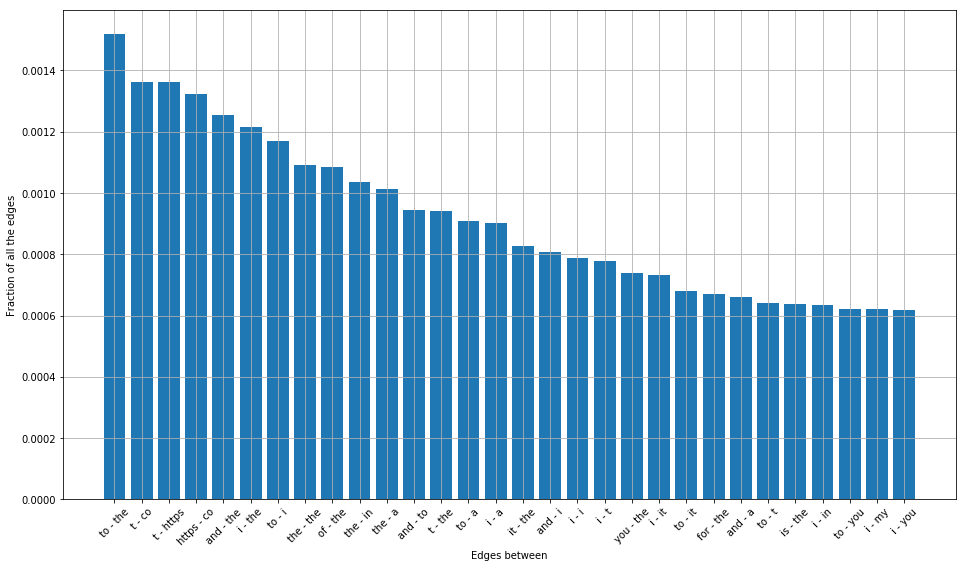

In [75]:
plt.figure(figsize=(16,9))
plt.bar(range(len(nums)), nums)
plt.xticks(range(len(nums)), labels, rotation=45)
plt.grid()
plt.xlabel('Edges between')
plt.ylabel('Fraction of all the edges');

It clearly seen, that a lot of non-real words (which are not part of the natural language) are here ('https', 't', 'co', etc.). However, it is promising that the word 'the' itself is very common -- as [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) states.

### Upcoming tasks

In the upcoming weeks I will gather sufficient number of tweets, clear the non-english words out, and examine the resulting networks.